In [1]:
%matplotlib inline
import importlib
import re
from pathlib import Path
import functools
import itertools
from functools import partial

import numpy as np
import scipy
import scipy.stats
import scipy.optimize
import scipy.integrate
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from numba import jit

import wlcsim
from wlcsim.chains import wlc
from wlcsim.analytical import rouse

def cart_to_sph(x, y, z):
    r = np.sqrt(x*x + y*y + z*z)
    phi = np.arctan2(y, x)
    theta = np.arccos(z/r)
    theta[r == 0] = 0.0
    return r, theta, phi


def sph_to_cart(r, theta, phi):
    #takes list rthetaphi (single coord)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [2]:
a = 1
r = np.linspace(0, a, 20)
theta = np.linspace(0, np.pi, 10)
phi = np.linspace(0, 2*np.pi, 10)
r, theta, phi = np.meshgrid(r, theta, phi)
x, y, z = sph_to_cart(r, theta, phi)
rp, thetap, phip = cart_to_sph(x, y, z)
xp, yp, zp = sph_to_cart(rp, thetap, phip)
assert(np.all(np.isclose(x, xp)))
assert(np.all(np.isclose(y, yp)))
assert(np.all(np.isclose(z, zp)))
assert(np.all(np.isclose(r, rp)))
# won't work because of degeneracy of angle transform for e.g. small "r"
#assert(np.all(np.isclose(phi, phip)))

## Green's functions

### Spherically confined

#### Plots

In [11]:
def plot_G_in_sphere(a, b, N, r0=None):
    # grid a sphere
    r = np.linspace(0, a, 20)
    theta = np.linspace(0, np.pi, 10)
    phi = np.linspace(0, 2*np.pi, 10)
    r, theta, phi = np.meshgrid(r, theta, phi)
    x, y, z = sph_to_cart(r, theta, phi)
    r0 = np.array([0, 0, 0.8*a])
    G = np.zeros_like(r)
    for i in range(r.shape[0]):
        for j in range(r.shape[1]):
            for k in range(r.shape[2]):
                ri = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
                G[i,j,k] = rouse.confined_G(ri, r0, N, b, a)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cnorm = mpl.colors.Normalize(vmin=0, vmax=1) # prob \in [0,1]
    cmap = mpl.cm.get_cmap('viridis')
    X = x.flatten() # scatter is not very smart about >1D arrays
    Y = y.flatten()
    Z = z.flatten()
    g = G.flatten()
    # ax.scatter(X, Y, Z, c=np.sqrt(X*X+Y*Y-Y*Z))
#     import pdb; pdb.set_trace()
    ax.scatter(X, Y, Z, c=cmap(cnorm(g)))

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'G after {N} Kuhn lengths of length {b} in radius {a}\nr0 = {r0}')
    
    sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm)
    

In [4]:
# parameters of chain/confinement
a = 1 # radius
b = 1 # kuhn length (nm)
N = 0.1 # number of Kuhn lengths in chain

In [6]:
# grid a sphere
r = np.linspace(0, a, 20)
theta = np.linspace(0, np.pi, 10)
phi = np.linspace(0, 2*np.pi, 10)
r, theta, phi = np.meshgrid(r, theta, phi, indexing='ij')
x, y, z = sph_to_cart(r, theta, phi)

# # alternate gridding
# x = np.linspace(-a, a, 10)
# y = x.copy(); z = x.copy()
# x, y, z = np.meshgrid(x, y, z)
# is_inside = np.sqrt(x*x+y*y+z*z) <= a
# x = x[is_inside]
# y = y[is_inside]
# z = z[is_inside]

In [7]:
r0 = np.array([0, 0, 0.8*a])
G = np.zeros_like(r)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        for k in range(r.shape[2]):
            ri = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
            G[i,j,k] = rouse.confined_G(ri, r0, N, b, a)

/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 0, 'Z Label')

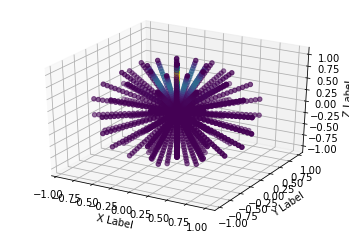

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cnorm = mpl.colors.Normalize(vmin=0, vmax=1) # prob \in [0,1]
cmap = mpl.cm.get_cmap('viridis')
X = x.flatten() # scatter is not very smart about >1D arrays
Y = y.flatten()
Z = z.flatten()
g = G.flatten()
# ax.scatter(X, Y, Z, c=np.sqrt(X*X+Y*Y-Y*Z))
ax.scatter(X, Y, Z, c=g)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:14: ComplexWarning: Casting complex values to real discards the imaginary part


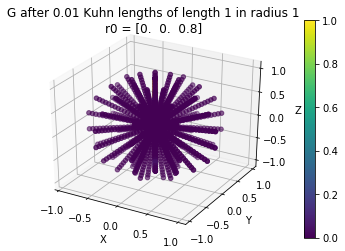

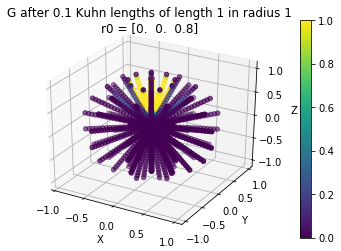

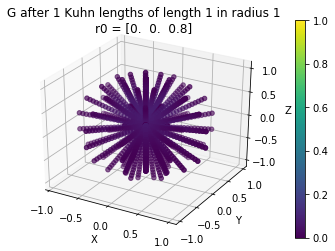

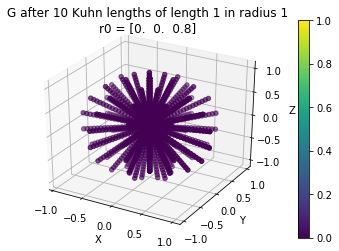

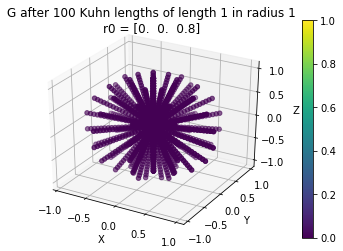

In [12]:
for n in [0.01, 0.1, 1, 10, 100]:
    plot_G_in_sphere(1, 1, n)

#### Integral

Testing approximate intrinsic error of a naive trap rule in this geometry...

In [8]:
hh = np.ones_like(r)

In [11]:
(4/3)*np.pi*a**3

4188790.2047863905

In [9]:
np.sum(hh * r*r*np.sin(theta) * dr*dtheta*dphi)

4262689.61470853

Seems to work okay, let's see how it does on a gaussian

In [6]:
sigma=1
def gaus3d(z,y, x):
    X = np.array([x,y,z])
    return 1/np.sqrt((2*np.pi)**3*sigma**3) * np.exp(-np.sum(X*X)/(2*sigma**2))
    

In [ ]:
# grid a box
x = np.linspace(-a, a, 100)
y = x.copy(); z = x.copy()
x, y, z = np.meshgrid(x, y, z, indexing='ij')
gg = np.zeros_like(r)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            gg[i,j,k] = gaus3d(z[i,j,k], y[i,j,k], x[i,j,k])

In [7]:
# grid a sphere
a = 100
r = np.linspace(0, a, 200)
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
r, theta, phi = np.meshgrid(r, theta, phi, indexing='ij')
x, y, z = sph_to_cart(r, theta, phi)
gg = np.zeros_like(r)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        for k in range(r.shape[2]):
            gg[i,j,k] = gaus3d(z[i,j,k], y[i,j,k], x[i,j,k])
dr = r[1,0,0] - r[0,0,0]
dtheta = theta[0,1,0] - theta[0,0,0]
dphi = phi[0,0,1] - phi[0,0,0]
np.sum(gg * r*r*np.sin(theta) * dr*dtheta*dphi)

1.0100162443909049

Similar error (should have been ~1), so we continue by summing our Green's function with this method

In [104]:
np.sum(G * r*r*np.sin(theta) * dr*dtheta*dphi)

1.1730759128950184e-07

Hahaha, obviously not normalized correctly....

#### Test tplquad

In [12]:
def ONE(z, y, x):
    return 1

In [15]:
scipy.integrate.tplquad(ONE, 0, a, gfun, hfun, qfun, rfun)

(0.0, 0)

In [14]:
@jit(nopython=True)
def gfun(x):
    return -np.sqrt(a**2 - x**2)
@jit(nopython=True)
def hfun(x):
    return np.sqrt(a**2 - x**2)
@jit(nopython=True)
def qfun(x,y):
    return -np.sqrt(a**2 - x**2 - y**2)
@jit(nopython=True)
def rfun(x,y):
    return -np.sqrt(a**2 - x**2 - y**2)


EPIC FAIL, WTF?

In [110]:
def G_test(z, y, x):
    return rouse.confined_G([x, y, z], r0, N, b, a)
scipy.integrate.tplquad(G_test, 0, a, gfun, hfun, qfun, rfun)

/home/bbeltr1/.miniconda/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(0.0, 0)

#### Compare to free G in large confinement

In [33]:
importlib.reload(rouse)

<module 'wlcsim.analytical.rouse' from '/home/bbeltr1/developer/wlcsim/wlcsim/analytical/rouse.py'>

here's the naive approach

In [34]:
# parameters of chain/confinement
a = 1 # radius
b = 1 # kuhn length (nm)
N = 0.1 # number of Kuhn lengths in chain
# grid a sphere
r = np.linspace(0, 1, 20)
theta = np.linspace(0, np.pi, 10)
phi = np.linspace(0, 2*np.pi, 10)
r, theta, phi = np.meshgrid(r, theta, phi)
x, y, z = sph_to_cart(r, theta, phi)
r0 = np.array([0, 0, 0])
G = np.zeros_like(r)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        for k in range(r.shape[2]):
            ri = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
            G[i,j,k] = rouse.confined_G(ri, r0, N, b, a)


/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


if we take too many l's, eventually we get NaN, because scipy.special.sph_harm fails to compute the spherical harmonnics of order like Y_100^100, for example.

In [46]:
# parameters of chain/confinement
a = 1 # radius
b = 1 # kuhn length (nm)
N = 0.1 # number of Kuhn lengths in chain
# grid a sphere
r = np.linspace(0, 1, 20)
theta = np.linspace(0, np.pi, 10)
phi = np.linspace(0, 2*np.pi, 10)
r, theta, phi = np.meshgrid(r, theta, phi)
x, y, z = sph_to_cart(r, theta, phi)
r0 = np.array([0, 0, 0])
G_more_l = np.zeros_like(r)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        for k in range(r.shape[2]):
            ri = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
            G_more_l[i,j,k] = rouse.confined_G(ri, r0, N, b, a, n_max=200,l_max=100)


/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


To be honest, since $r'$ is $\vec{0}$, we know the Green's function will be spherically symmetric, so only the $l=m=0$ term of the expansion is needed. In addition, after like 20 or so zeros of the spherical BesselJ's, the coefficients of the expansion are smaller than floating eps, so we can just do

In [13]:
# parameters of chain/confinement
a = 1 # radius
b = 1 # kuhn length (nm)
N = 0.1 # number of Kuhn lengths in chain
# grid a sphere
r = np.linspace(0, 1, 20)
theta = np.linspace(0, np.pi, 10)
phi = np.linspace(0, 2*np.pi, 10)
r, theta, phi = np.meshgrid(r, theta, phi)
x, y, z = sph_to_cart(r, theta, phi)
r0 = np.array([0, 0, 0])
G_less_ln = np.zeros_like(r)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        for k in range(r.shape[2]):
            ri = np.array([x[i,j,k], y[i,j,k], z[i,j,k]])
            G_less_ln[i,j,k] = rouse.confined_G(ri, r0, N, b, a, n_max=20, l_max=0)


/home/bbeltr1/.miniconda/lib/python3.7/site-packages/ipykernel/__main__.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


Should evaluate to a Gaussian with std deviation $Nb^2$

In [14]:
gaus = ( 3/(2*np.pi * (N*b**2)) )**(3/2) * np.exp(-(3/2) * r**2/(N*b**2))

In [48]:
G

array([[[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 8.83548047e+00, 8.83548047e+00, ...,
         8.83548047e+00, 8.83548047e+00, 8.83548047e+00],
        ...,
        [6.34305397e-05, 6.34305397e-05, 6.34305397e-05, ...,
         6.34305397e-05, 6.34305397e-05, 6.34305397e-05],
        [1.41469054e-05, 1.41469054e-05, 1.41469054e-05, ...,
         1.41469054e-05, 1.41469054e-05, 1.41469054e-05],
        [7.26011550e-21, 7.26011550e-21, 7.26011550e-21, ...,
         7.26011550e-21, 7.26011550e-21, 7.26011550e-21]],

       [[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 

In [45]:
G_more_l

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [15]:
G_less_ln

array([[[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 8.83548047e+00, 8.83548047e+00, ...,
         8.83548047e+00, 8.83548047e+00, 8.83548047e+00],
        ...,
        [6.34305397e-05, 6.34305397e-05, 6.34305397e-05, ...,
         6.34305397e-05, 6.34305397e-05, 6.34305397e-05],
        [1.41469054e-05, 1.41469054e-05, 1.41469054e-05, ...,
         1.41469054e-05, 1.41469054e-05, 1.41469054e-05],
        [7.26011550e-21, 7.26011550e-21, 7.26011550e-21, ...,
         7.26011550e-21, 7.26011550e-21, 7.26011550e-21]],

       [[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 

In [16]:
gaus

array([[[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 8.83548047e+00, 8.83548047e+00, ...,
         8.83548047e+00, 8.83548047e+00, 8.83548047e+00],
        ...,
        [6.35724869e-05, 6.35724869e-05, 6.35724869e-05, ...,
         6.35724869e-05, 6.35724869e-05, 6.35724869e-05],
        [1.48483263e-05, 1.48483263e-05, 1.48483263e-05, ...,
         1.48483263e-05, 1.48483263e-05, 1.48483263e-05],
        [3.19150002e-06, 3.19150002e-06, 3.19150002e-06, ...,
         3.19150002e-06, 3.19150002e-06, 3.19150002e-06]],

       [[1.04330690e+01, 1.04330690e+01, 1.04330690e+01, ...,
         1.04330690e+01, 1.04330690e+01, 1.04330690e+01],
        [1.00084449e+01, 1.00084449e+01, 1.00084449e+01, ...,
         1.00084449e+01, 1.00084449e+01, 1.00084449e+01],
        [8.83548047e+00, 

YESSSSS

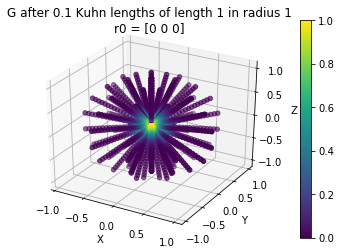

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cnorm = mpl.colors.Normalize(vmin=0, vmax=1) # prob \in [0,1]
cmap = mpl.cm.get_cmap('viridis')
X = x.flatten() # scatter is not very smart about >1D arrays
Y = y.flatten()
Z = z.flatten()
g = G_less_ln.flatten()
# ax.scatter(X, Y, Z, c=np.sqrt(X*X+Y*Y-Y*Z))
ax.scatter(X, Y, Z, c=g)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'G after {N} Kuhn lengths of length {b} in radius {a}\nr0 = {r0}')

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
    

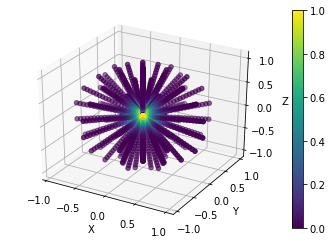

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cnorm = mpl.colors.Normalize(vmin=0, vmax=1) # prob \in [0,1]
cmap = mpl.cm.get_cmap('viridis')
X = x.flatten() # scatter is not very smart about >1D arrays
Y = y.flatten()
Z = z.flatten()
ga = gaus.flatten()
# ax.scatter(X, Y, Z, c=np.sqrt(X*X+Y*Y-Y*Z))
ax.scatter(X, Y, Z, c=ga)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title(f'G after {N} Kuhn lengths of length {b} in radius {a}\nr0 = {r0}')

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
    

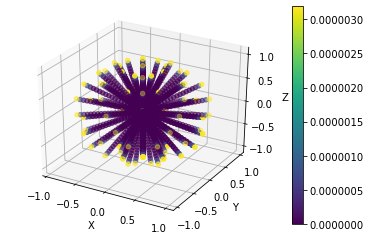

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = x.flatten() # scatter is not very smart about >1D arrays
Y = y.flatten()
Z = z.flatten()
ga = np.abs(gaus - G_less_ln).flatten()

cnorm = mpl.colors.Normalize(vmin=0, vmax=np.max(ga)) # prob \in [0,1]
cmap = mpl.cm.get_cmap('viridis')

# ax.scatter(X, Y, Z, c=np.sqrt(X*X+Y*Y-Y*Z))
ax.scatter(X, Y, Z, c=ga)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title(f'G after {N} Kuhn lengths of length {b} in radius {a}\nr0 = {r0}')

sm = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm)
    

### Free Green's function

I mean, it's just a Gaussian, centered at $r'$, with std dev $Nb^2$....